# Brain Tumor MRI Classification

> **Model:** EfficientNetB0 (Transfer Learning) &nbsp;|&nbsp; **Dataset:** [Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset) &nbsp;|&nbsp; **Classes:** Glioma, Meningioma, Pituitary, No Tumor

---

## 1. Setup, Mount & Download Dataset


In [1]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Configure Kaggle (ensure kaggle.json is in the root of your Drive)
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive"

# Download & extract dataset
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -qo brain-tumor-mri-dataset.zip -d /content/dataset

print("Dataset downloaded and extracted successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset downloaded and extracted successfully!


## 2. Imports & Configuration


In [2]:
import tensorflow as tf
import keras
from keras import layers, models, ops
from keras.applications import EfficientNetB0
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os

print(f"Keras Version: {keras.__version__}")

# Constants
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 20  # More epochs for better convergence (EarlyStopping will handle overfitting)
dataset_dir = '/content/dataset/Training'

# --- Model Paths ---
SAVED_MODEL_PATH = '/content/drive/MyDrive/best_tumor_classifier_v1.keras'
CHECKPOINT_PATH = '/content/drive/MyDrive/tumor_classifier_model.keras'

# Flag to track if model was loaded or needs training
MODEL_LOADED = False

Keras Version: 3.10.0


## 3. Data Preprocessing & Augmentation


In [3]:
import keras
from keras import layers, models
from keras.callbacks import ModelCheckpoint, EarlyStopping

# 1. Load Data
print("Loading Training Data...")
train_ds = keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True
)

# --- CAPTURE CLASS NAMES HERE (works in Keras 3) ---
class_names = train_ds.class_names
num_classes = len(class_names)

print("Loading Validation Data...")
val_ds = keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

# 2. Setup Augmentation (Keras 3 compatible)
# Note: RandomShear may not be available in all Keras 3 versions
data_augmentation = keras.Sequential([
    layers.RandomRotation(factor=0.05),        # ~18 degrees
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomZoom(0.1),
    layers.RandomFlip("horizontal"),
    layers.RandomContrast(factor=0.1),         # Added: helps generalization
    layers.RandomBrightness(factor=0.1),       # Added: helps generalization
])

# 3. Apply Augmentation ONLY to training set
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=tf.data.AUTOTUNE)

# 4. Performance optimization: cache and prefetch
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

# Build class_name → index mapping (replaces Keras 2's .class_indices)
class_indices = {name: i for i, name in enumerate(class_names)}
print(f"Class Mappings: {class_indices}")
print(f"Number of classes: {num_classes}")

Loading Training Data...
Found 5600 files belonging to 4 classes.
Using 4480 files for training.
Loading Validation Data...
Found 5600 files belonging to 4 classes.
Using 1120 files for validation.
Class Mappings: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Number of classes: 4


## 4. Model Architecture

> Loads pre-trained model from Google Drive if available, otherwise builds EfficientNetB0 from scratch.


In [4]:
# ==============================================================
# STRATEGY: Try loading saved model first, build only if not found
# ==============================================================

def build_model(num_classes):
    """Build EfficientNetB0 transfer learning model from scratch."""
    # 1. Load Base Model (Pre-trained on ImageNet)
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    # 2. Freeze the base model initially
    base_model.trainable = False
    
    # 3. Add Custom Head (improved architecture)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)        # Added: stabilizes training
    x = Dropout(0.4)(x)               # Increased dropout
    x = Dense(256, activation='relu')(x)  # Wider layer
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # 4. Final Model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

# --- Try loading saved model ---
if os.path.exists(SAVED_MODEL_PATH):
    print(f"✅ Found saved model at: {SAVED_MODEL_PATH}")
    print("Loading model...")
    model = keras.models.load_model(SAVED_MODEL_PATH)
    MODEL_LOADED = True
    print("Model loaded successfully!")
    model.summary()
elif os.path.exists(CHECKPOINT_PATH):
    print(f"✅ Found checkpoint model at: {CHECKPOINT_PATH}")
    print("Loading model...")
    model = keras.models.load_model(CHECKPOINT_PATH)
    MODEL_LOADED = True
    print("Model loaded successfully!")
    model.summary()
else:
    print("❌ No saved model found. Building from scratch...")
    model, base_model = build_model(num_classes)
    MODEL_LOADED = False
    
    # Compile for initial training (frozen base)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()
    print("\n⚠️ Model built from scratch. Run the training cell next.")

✅ Found saved model at: /content/drive/MyDrive/best_tumor_classifier_v1.keras
Loading model...
Model loaded successfully!


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 12,558,121 (47.91 MB)

 Trainable params: 4,172,032 (15.92 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 8,344,066 (31.83 MB)

## 5. Training

> **Phase 1:** Feature extraction (frozen base) &nbsp;|&nbsp; **Phase 2:** Fine-tuning (top 30% unfrozen with lower LR)
>
> _Skipped automatically if a saved model is loaded._


In [5]:
import keras

if MODEL_LOADED:
    print("✅ Model was loaded from Drive — skipping training.")
    print("If you want to fine-tune, set MODEL_LOADED = False and re-run this cell.")
    history = None
else:
    print("🚀 Starting training pipeline...\n")
    
    # ===== PHASE 1: Train with frozen base (feature extraction) =====
    print("=" * 50)
    print("PHASE 1: Feature Extraction (Base Frozen)")
    print("=" * 50)
    
    callbacks_phase1 = [
        keras.callbacks.ModelCheckpoint(
            CHECKPOINT_PATH,
            save_best_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
    ]
    
    history_phase1 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=callbacks_phase1
    )
    
    # ===== PHASE 2: Fine-tuning (unfreeze top layers of base) =====
    print("\n" + "=" * 50)
    print("PHASE 2: Fine-Tuning (Unfreezing top layers)")
    print("=" * 50)
    
    # Unfreeze the top ~30% of EfficientNet layers for fine-tuning
    base_model.trainable = True
    total_layers = len(base_model.layers)
    freeze_until = int(total_layers * 0.7)  # Keep bottom 70% frozen
    
    for layer in base_model.layers[:freeze_until]:
        layer.trainable = False
    
    trainable_count = sum(1 for l in base_model.layers if l.trainable)
    print(f"Unfroze {trainable_count}/{total_layers} base model layers")
    
    # Re-compile with lower LR for fine-tuning
    model.compile(
        optimizer=Adam(learning_rate=1e-4),  # 10x lower LR for fine-tuning
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    callbacks_phase2 = [
        keras.callbacks.ModelCheckpoint(
            CHECKPOINT_PATH,
            save_best_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
    ]
    
    history_phase2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks_phase2
    )
    
    # Merge histories for plotting
    history = history_phase2  # Use phase 2 as primary for plots
    
    # Save final model
    model.save(SAVED_MODEL_PATH)
    print(f"\n✅ Final model saved to: {SAVED_MODEL_PATH}")

✅ Model was loaded from Drive — skipping training.
If you want to fine-tune, set MODEL_LOADED = False and re-run this cell.


## 6. Evaluation — Confusion Matrix & Classification Report


Loading test data from: /content/dataset/Testing
Found 1600 files belonging to 4 classes.
Test classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


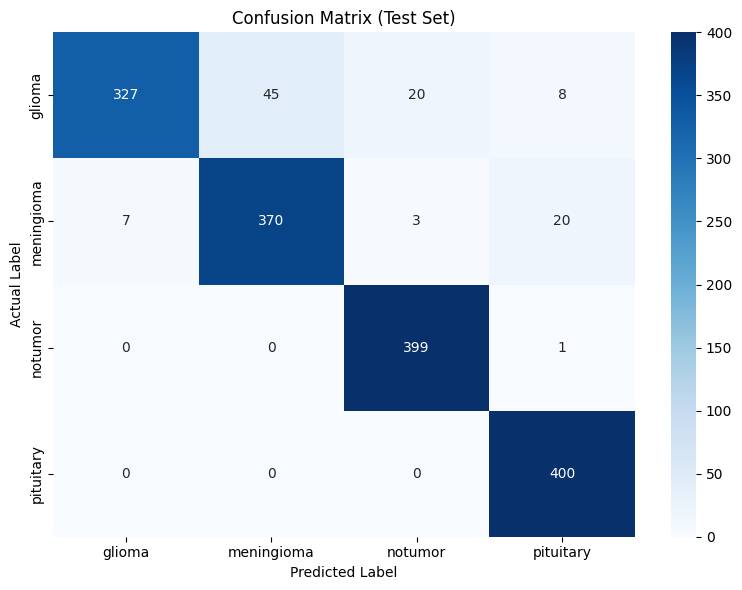


Classification Report (Test Set):
              precision    recall  f1-score   support

      glioma       0.98      0.82      0.89       400
  meningioma       0.89      0.93      0.91       400
     notumor       0.95      1.00      0.97       400
   pituitary       0.93      1.00      0.97       400

    accuracy                           0.94      1600
   macro avg       0.94      0.94      0.93      1600
weighted avg       0.94      0.94      0.93      1600



In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load the dedicated test set (separate from training/validation)
test_dir = '/content/dataset/Testing'
print(f"Loading test data from: {test_dir}")

test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)
print(f"Test classes: {test_ds.class_names}")

# Collect predictions
y_true, y_pred = [], []
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

y_true, y_pred = np.array(y_true), np.array(y_pred)
all_labels = list(range(len(class_names)))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=all_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_true, y_pred, labels=all_labels,
                            target_names=class_names, zero_division=0))

## 7. Training Curves

> _Only available when the model was trained in this session._


In [7]:
# Plot accuracy and loss
if history is not None:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
else:
    print("No training history available (model was loaded from Drive).")

No training history available (model was loaded from Drive).


## 8. Inference — Custom Images

> Drop your MRI images into `Test_Images/` on Google Drive and run this cell.


Found 4 image(s). Running inference...



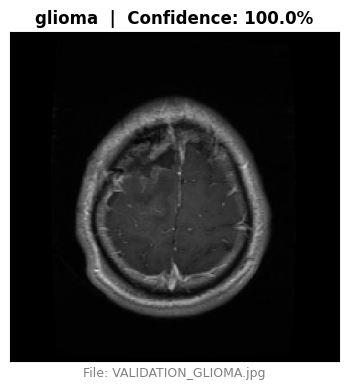

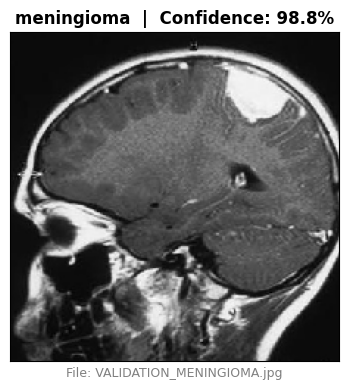

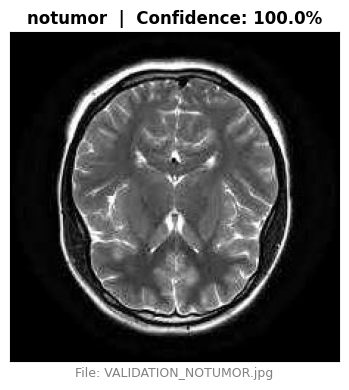

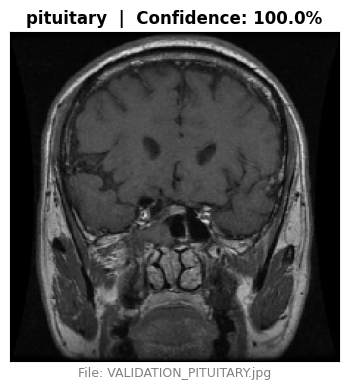

In [12]:
from keras.utils import load_img, img_to_array

test_folder_path = '/content/drive/MyDrive/Test_Images'
idx_to_class = {i: name for i, name in enumerate(class_names)}

def predict_single_image(img_path):
    """Load an MRI image, run inference, and display the result."""
    filename = os.path.basename(img_path)
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = np.expand_dims(img_to_array(img), axis=0)  # [0-255], no rescaling

    prediction = model.predict(img_array, verbose=0)
    class_idx = np.argmax(prediction)
    confidence = np.max(prediction)
    label = idx_to_class[class_idx]

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"{label}  |  Confidence: {confidence*100:.1f}%", fontsize=12, fontweight='bold')
    plt.xlabel(f"File: {filename}", fontsize=9, color='gray')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

# --- Run ---
if os.path.exists(test_folder_path):
    image_files = sorted([f for f in os.listdir(test_folder_path)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    if not image_files:
        print("Folder is empty — upload MRI images to Test_Images/ on Drive.")
    else:
        print(f"Found {len(image_files)} image(s). Running inference...\n")
        for fname in image_files:
            predict_single_image(os.path.join(test_folder_path, fname))
else:
    print(f"Folder not found: {test_folder_path}")

## 9. Cross-Dataset Validation

> Tests generalization on [Navoneel's Brain MRI Dataset](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection) (binary: tumor vs. no tumor).


In [9]:
import os

!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection -p /content/external_test
!unzip -qo /content/external_test/brain-mri-images-for-brain-tumor-detection.zip -d /content/external_test/data

print("External validation dataset ready.")

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
External validation dataset ready.


In [10]:
from keras.utils import load_img, img_to_array

base_path = '/content/external_test/data'
yes_path = os.path.join(base_path, 'yes')
no_path  = os.path.join(base_path, 'no')
idx_to_class = {i: name for i, name in enumerate(class_names)}

def get_pred_label(img_path):
    """Return predicted class name for a single image."""
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = np.expand_dims(img_to_array(img), axis=0)
    prediction = model.predict(img_array, verbose=0)
    return idx_to_class[np.argmax(prediction)]

# --- Evaluate ---
correct_no = total_no = correct_yes = total_yes = 0

print("Cross-Dataset Validation")
print("=" * 40)

# Healthy images → expect 'notumor'
if os.path.exists(no_path):
    for f in sorted(os.listdir(no_path)):
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            total_no += 1
            if get_pred_label(os.path.join(no_path, f)) == 'notumor':
                correct_no += 1

# Tumor images → expect any tumor class
if os.path.exists(yes_path):
    for f in sorted(os.listdir(yes_path)):
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            total_yes += 1
            if get_pred_label(os.path.join(yes_path, f)) in ['glioma', 'meningioma', 'pituitary']:
                correct_yes += 1

# Report
specificity = (correct_no / total_no * 100) if total_no else 0
sensitivity = (correct_yes / total_yes * 100) if total_yes else 0
overall     = ((correct_no + correct_yes) / (total_no + total_yes) * 100) if (total_no + total_yes) else 0

print(f"{'Metric':<30} {'Value':>10}")
print("-" * 40)
print(f"{'Healthy images tested':<30} {total_no:>10}")
print(f"{'Correctly identified healthy':<30} {correct_no:>10}")
print(f"{'Specificity':<30} {specificity:>9.2f}%")
print("-" * 40)
print(f"{'Tumor images tested':<30} {total_yes:>10}")
print(f"{'Correctly identified tumor':<30} {correct_yes:>10}")
print(f"{'Sensitivity':<30} {sensitivity:>9.2f}%")
print("=" * 40)
print(f"{'OVERALL ACCURACY':<30} {overall:>9.2f}%")

Cross-Dataset Validation
Metric                              Value
----------------------------------------
Healthy images tested                  98
Correctly identified healthy           98
Specificity                       100.00%
----------------------------------------
Tumor images tested                   155
Correctly identified tumor             89
Sensitivity                        57.42%
OVERALL ACCURACY                   73.91%


## 10. Save Model to Google Drive


In [ ]:
# # Save the model to your Google Drive
# model_path = '/content/drive/MyDrive/best_tumor_classifier_v1.keras'
# model.save(model_path)

# print(f"Model saved successfully to: {model_path}")